# **Deforum Stable Diffusion v0.6**
[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings). You need to get the ckpt file and put it on your Google Drive first to use this. It can be downloaded from [HuggingFace](https://huggingface.co/CompVis/stable-diffusion).

Notebook by [deforum](https://discord.gg/upmXXsrwZc)

In [1]:
#@markdown **NVIDIA GPU**
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

NVIDIA RTX A6000, 49140 MiB, 47737 MiB


# Setup

In [2]:
#@markdown **Model and Output Paths**
def get_model_output_paths():

    models_path = "models" #@param {type:"string"}
    output_path = "output" #@param {type:"string"}

    #@markdown **Google Drive Path Variables (Optional)**
    mount_google_drive = True #@param {type:"boolean"}
    force_remount = False

    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'

    if 'google.colab' in str(ipy):
        if mount_google_drive:
            from google.colab import drive # type: ignore
            try:
                drive_path = "/content/drive"
                drive.mount(drive_path,force_remount=force_remount)
                models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
                output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
                models_path = models_path_gdrive
                output_path = output_path_gdrive
            except:
                print("..error mounting drive or with drive path variables")
                print("..reverting to default path variables")

    models_path = os.path.abspath(models_path)
    output_path = os.path.abspath(output_path)
    os.makedirs(models_path, exist_ok=True)
    os.makedirs(output_path, exist_ok=True)

    print(f"models_path: {models_path}")
    print(f"output_path: {output_path}")

    return models_path, output_path

models_path, output_path = get_model_output_paths()

def setup_environment():

    print_subprocess = False

    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'

    if 'google.colab' in str(ipy):
        import subprocess, time
        print("Setting up environment...")
        start_time = time.time()
        all_process = [
            ['pip', 'install', 'torch==1.12.1+cu113', 'torchvision==0.13.1+cu113', '--extra-index-url', 'https://download.pytorch.org/whl/cu113'],
            ['pip', 'install', 'omegaconf==2.2.3', 'einops==0.4.1', 'pytorch-lightning==1.7.4', 'torchmetrics==0.9.3', 'torchtext==0.13.1', 'transformers==4.21.2', 'kornia==0.6.7'],
            ['git', 'clone',  '-b', 'local', 'https://github.com/deforum/stable-diffusion'],
            ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq','scikit-learn'],
        ]
        for process in all_process:
            running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
            if print_subprocess:
                print(running)

        with open('stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
            f.write('')

        sys.path.extend([
            'stable-diffusion/',
            'stable-diffusion/src',
        ])

        end_time = time.time()
        print(f"Environment set up in {end_time-start_time:.0f} seconds")
        
    else:

        sys.path.extend([
            'src'
        ])

    return

setup_environment()

# import
import torch
import gc
import time
import random
from types import SimpleNamespace
import clip
from IPython import display

from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode
from helpers.aesthetics import load_aesthetics_model

#@markdown **Select and Load Model**

def load_model():

    import requests
    import torch
    from ldm.util import instantiate_from_config
    from omegaconf import OmegaConf
    from transformers import logging
    logging.set_verbosity_error()

    model_config = "v1-inference.yaml" #@param ["custom","v1-inference.yaml"]
    model_checkpoint =  "sd-v1-4.ckpt" #@param ["custom","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]

    custom_config_path = "" #@param {type:"string"}
    custom_checkpoint_path = "" #@param {type:"string"}

    load_on_run_all = True
    half_precision = True
    check_sha256 = True

    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'

    if 'google.colab' in str(ipy):
        path_extend = "stable-diffusion"
    else:
        path_extend = ""

    model_map = {
        "sd-v1-4-full-ema.ckpt": {
            'sha256': '14749efc0ae8ef0329391ad4436feb781b402f4fece4883c7ad8d10556d8a36a',
            'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/blob/main/sd-v1-4-full-ema.ckpt',
            'requires_login': True,
            },
        "sd-v1-4.ckpt": {
            'sha256': 'fe4efff1e174c627256e44ec2991ba279b3816e364b49f9be2abc0b3ff3f8556',
            'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt',
            'requires_login': True,
            },
        "sd-v1-3-full-ema.ckpt": {
            'sha256': '54632c6e8a36eecae65e36cb0595fab314e1a1545a65209f24fde221a8d4b2ca',
            'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-3-original/blob/main/sd-v1-3-full-ema.ckpt',
            'requires_login': True,
            },
        "sd-v1-3.ckpt": {
            'sha256': '2cff93af4dcc07c3e03110205988ff98481e86539c51a8098d4f2236e41f7f2f',
            'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-3-original/resolve/main/sd-v1-3.ckpt',
            'requires_login': True,
            },
        "sd-v1-2-full-ema.ckpt": {
            'sha256': 'bc5086a904d7b9d13d2a7bccf38f089824755be7261c7399d92e555e1e9ac69a',
            'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/blob/main/sd-v1-2-full-ema.ckpt',
            'requires_login': True,
            },
        "sd-v1-2.ckpt": {
            'sha256': '3b87d30facd5bafca1cbed71cfb86648aad75d1c264663c0cc78c7aea8daec0d',
            'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/resolve/main/sd-v1-2.ckpt',
            'requires_login': True,
            },
        "sd-v1-1-full-ema.ckpt": {
            'sha256': 'efdeb5dc418a025d9a8cc0a8617e106c69044bc2925abecc8a254b2910d69829',
            'url':'https://huggingface.co/CompVis/stable-diffusion-v-1-1-original/resolve/main/sd-v1-1-full-ema.ckpt',
            'requires_login': True,
            },
        "sd-v1-1.ckpt": {
            'sha256': '86cd1d3ccb044d7ba8db743d717c9bac603c4043508ad2571383f954390f3cea',
            'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-1-original/resolve/main/sd-v1-1.ckpt',
            'requires_login': True,
            },
        "robo-diffusion-v1.ckpt": {
            'sha256': '244dbe0dcb55c761bde9c2ac0e9b46cc9705ebfe5f1f3a7cc46251573ea14e16',
            'url': 'https://huggingface.co/nousr/robo-diffusion/resolve/main/models/robo-diffusion-v1.ckpt',
            'requires_login': False,
            },
        "wd-v1-3-float16.ckpt": {
            'sha256': '4afab9126057859b34d13d6207d90221d0b017b7580469ea70cee37757a29edd',
            'url': 'https://huggingface.co/hakurei/waifu-diffusion-v1-3/resolve/main/wd-v1-3-float16.ckpt',
            'requires_login': False,
            },
    }

    # config path
    ckpt_config_path = custom_config_path if model_config == "custom" else os.path.join(models_path, model_config)
    if os.path.exists(ckpt_config_path):
        print(f"{ckpt_config_path} exists")
    else:
        ckpt_config_path = os.path.join(path_extend,"configs","v1-inference.yaml")
        
    ckpt_config_path = os.path.abspath(ckpt_config_path)

    # checkpoint path or download
    ckpt_path = custom_checkpoint_path if model_checkpoint == "custom" else os.path.join(models_path, model_checkpoint)
    ckpt_valid = True
    if os.path.exists(ckpt_path):
        pass
    elif 'url' in model_map[model_checkpoint]:
        url = model_map[model_checkpoint]['url']

        # CLI dialogue to authenticate download
        if model_map[model_checkpoint]['requires_login']:
            print("This model requires an authentication token")
            print("Please ensure you have accepted the terms of service before continuing.")

            username = input("[What is your huggingface username?]: ")
            token = input("[What is your huggingface token?]: ")

            _, path = url.split("https://")

            url = f"https://{username}:{token}@{path}"

        # contact server for model
        print(f"..attempting to download {model_checkpoint}...this may take a while")
        ckpt_request = requests.get(url)
        request_status = ckpt_request.status_code

        # inform user of errors
        if request_status == 403:
            raise ConnectionRefusedError("You have not accepted the license for this model.")
        elif request_status == 404:
            raise ConnectionError("Could not make contact with server")
        elif request_status != 200:
            raise ConnectionError(f"Some other error has ocurred - response code: {request_status}")

        # write to model path
        with open(os.path.join(models_path, model_checkpoint), 'wb') as model_file:
            model_file.write(ckpt_request.content)
    else:
        print(f"Please download model checkpoint and place in {os.path.join(models_path, model_checkpoint)}")
        ckpt_valid = False
        
    print(f"config_path: {ckpt_config_path}")
    print(f"ckpt_path: {ckpt_path}")

    if check_sha256 and model_checkpoint != "custom" and ckpt_valid:
        import hashlib
        print("..checking sha256")
        with open(ckpt_path, "rb") as f:
            bytes = f.read() 
            hash = hashlib.sha256(bytes).hexdigest()
            del bytes
        if model_map[model_checkpoint]["sha256"] == hash:
            print("..hash is correct")
        else:
            print("..hash in not correct")
            ckpt_valid = False

    def load_model_from_config(config, ckpt, verbose=False, device='cuda', half_precision=True,print_flag=False):
        map_location = "cuda" # ["cpu", "cuda"]
        print(f"..loading model")
        pl_sd = torch.load(ckpt, map_location=map_location)
        if "global_step" in pl_sd:
            if print_flag:
                print(f"Global Step: {pl_sd['global_step']}")
        sd = pl_sd["state_dict"]
        model = instantiate_from_config(config.model)
        m, u = model.load_state_dict(sd, strict=False)
        if print_flag:
            if len(m) > 0 and verbose:
                print("missing keys:")
                print(m)
            if len(u) > 0 and verbose:
                print("unexpected keys:")
                print(u)

        if half_precision:
            model = model.half().to(device)
        else:
            model = model.to(device)
        model.eval()
        return model

    if load_on_run_all and ckpt_valid:
        local_config = OmegaConf.load(f"{ckpt_config_path}")
        model = load_model_from_config(local_config, f"{ckpt_path}", half_precision=half_precision)
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        model = model.to(device)

    autoencoder_version = "sd-v1" #TODO this will be different for different models
    model.linear_decode = make_linear_decode(autoencoder_version, device)

    return model, device

model, device = load_model()

models_path: /home/scndn/ai/stable-diffusion/models
output_path: /home/scndn/ai/stable-diffusion/output


/home/scndn/anaconda3/envs/dsd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


config_path: /home/scndn/ai/stable-diffusion/configs/v1-inference.yaml
ckpt_path: /home/scndn/ai/stable-diffusion/models/wd-v1-3-float16.ckpt
..checking sha256
..hash is correct
..loading model


# Settings

### Animation Settings

In [3]:
def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = 'None' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 1000 #@param {type:"number"}
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(1.04)"#@param {type:"string"}
    translation_x = "0:(10*sin(2*3.14*t/10))"#@param {type:"string"}
    translation_y = "0:(0)"#@param {type:"string"}
    translation_z = "0:(10)"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0:(0)"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.02)"#@param {type:"string"}
    strength_schedule = "0: (0.65)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB'] {type:'string'}
    diffusion_cadence = '1' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 4 #@param {type:"number"}
    
    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20220829210106" #@param {type:"string"}

    return locals()

### Prompts
`animation_mode: None` batches on list of *prompts*. `animation_mode: 2D` uses *animation_prompts* key frame sequence

In [4]:
prompts = [
    "a beautiful lake by Asher Brown Durand, trending on Artstation", # the first prompt I want
    "a beautiful portrait of a woman by Artgerm, trending on Artstation", # the second prompt I want
    #"this prompt I don't want it I commented it out",
    #"a nousr robot, trending on Artstation", # use "nousr robot" with the robot diffusion model (see model_checkpoint setting)
    #"touhou 1girl komeiji_koishi portrait, green hair", # waifu diffusion prompts can use danbooru tag groups (see model_checkpoint)
    #"this prompt has weights if prompt weighting enabled:2 can also do negative:-2", # (see prompt_weighting)
]

animation_prompts = {
    0: "a beautiful apple, trending on Artstation",
    20: "a beautiful banana, trending on Artstation",
    30: "a beautiful coconut, trending on Artstation",
    40: "a beautiful durian, trending on Artstation",
}

# Run

Global seed set to 2013057373


Saving to /home/scndn/ai/stable-diffusion/output/2022-10/StableFun/20221016235019_*
Prompt 1 of 2
a beautiful lake by Asher Brown Durand, trending on Artstation
Batch 1 of 4


100%|██████████| 80/80 [00:51<00:00,  1.56it/s]


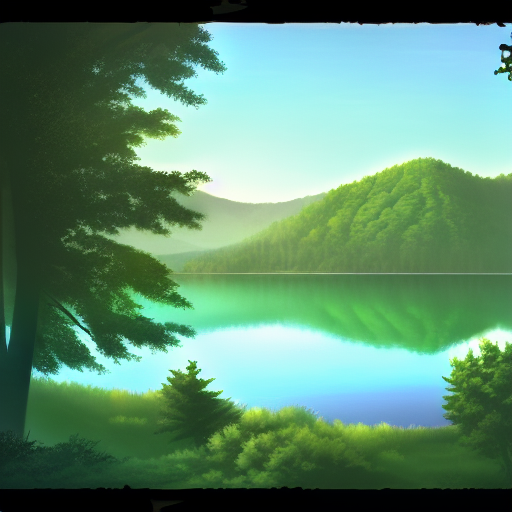

Global seed set to 2013057374


Batch 2 of 4


100%|██████████| 80/80 [00:51<00:00,  1.55it/s]


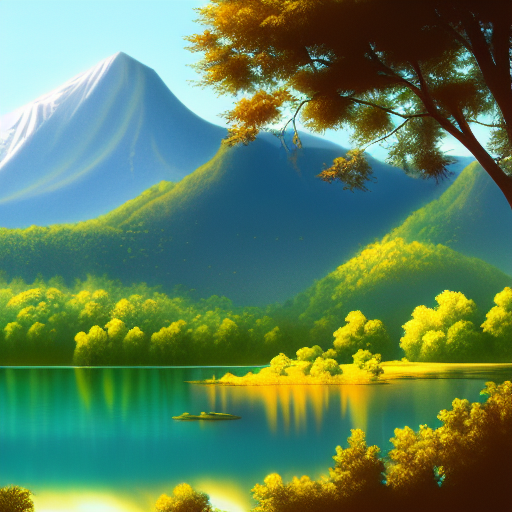

Global seed set to 2013057375


Batch 3 of 4


100%|██████████| 80/80 [00:53<00:00,  1.51it/s]


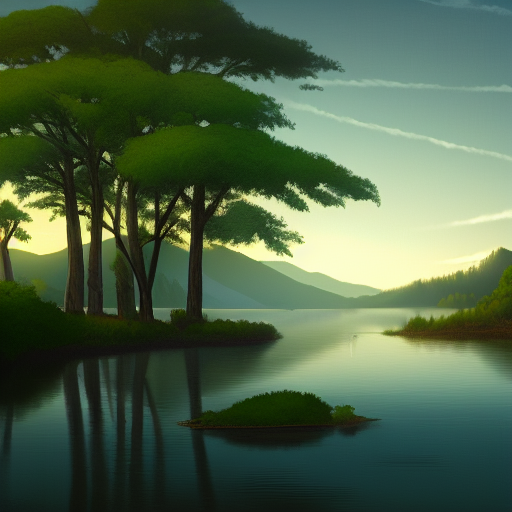

Global seed set to 2013057376


Batch 4 of 4


100%|██████████| 80/80 [00:53<00:00,  1.49it/s]


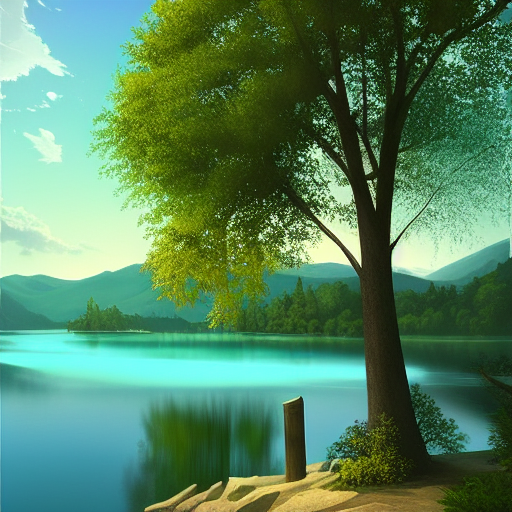

Global seed set to 2013057377


Prompt 2 of 2
a beautiful portrait of a woman by Artgerm, trending on Artstation
Batch 1 of 4


100%|██████████| 80/80 [00:51<00:00,  1.55it/s]


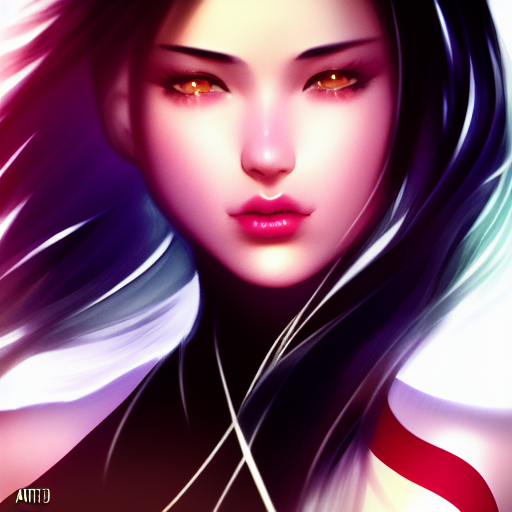

Global seed set to 2013057378


Batch 2 of 4


100%|██████████| 80/80 [00:50<00:00,  1.60it/s]


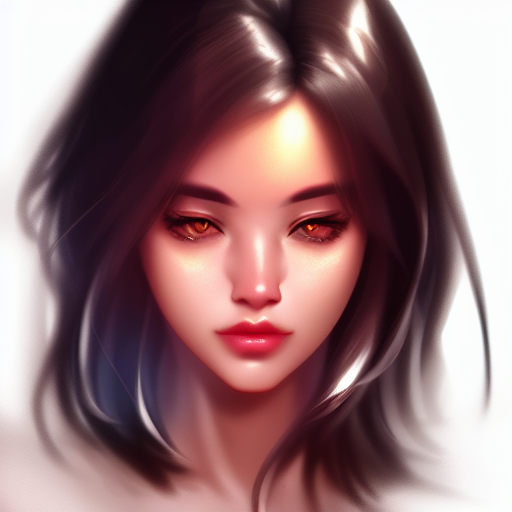

Global seed set to 2013057379


Batch 3 of 4


100%|██████████| 80/80 [00:50<00:00,  1.60it/s]


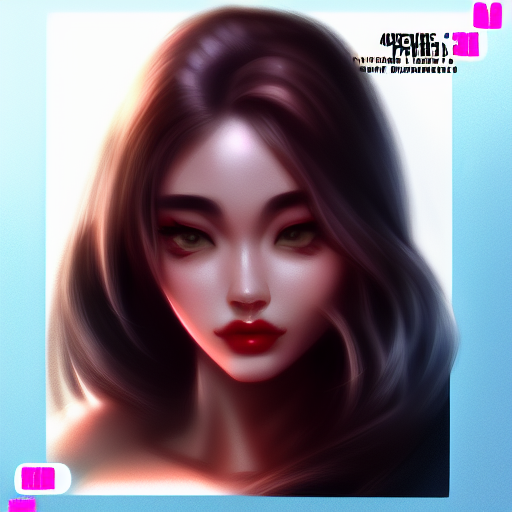

Global seed set to 2013057380


Batch 4 of 4


100%|██████████| 80/80 [00:51<00:00,  1.55it/s]


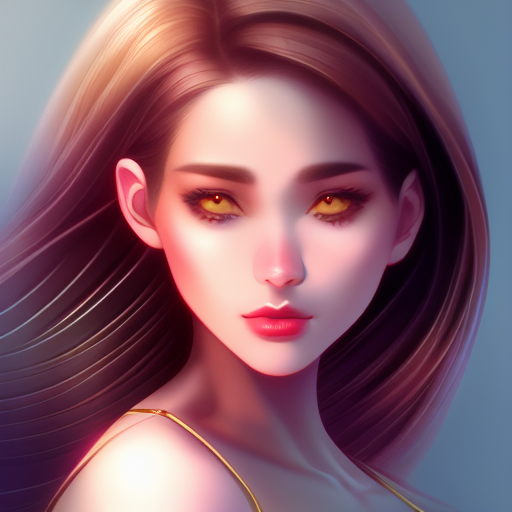

In [6]:
#@markdown **Load Settings**
override_settings_with_file = False #@param {type:"boolean"}
custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

def Root():
    return locals()

def DeforumArgs():
    #@markdown **Image Settings**
    W = 512 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'euler_ancestral' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim"]
    steps = 80 #@param
    scale = 12 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Prompt Settings**
    prompt_weighting = False #@param {type:"boolean"}
    normalize_prompt_weights = True #@param {type:"boolean"}
    log_weighted_subprompts = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 4 #@param
    batch_name = "StableFun" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random"]
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.0 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Conditioning Settings**
    init_mse_scale = 0 #@param {type:"number"}
    blue_loss_scale = 0
    ignore_sat_scale = 5 #@param 

    clip_loss_scale = 100 #@param {type:"number"}
    aesthetics_loss_scale = 10 #@param {type:"number"}
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    colormatch_loss_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    
    grad_threshold_type = 'schedule' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_start = 0.10 #@param
    clamp_stop = 0.01 #@param
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    gradient_wrt = 'x' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}

    n_samples = 1 # doesnt do anything
    precision = 'autocast' 
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_c = None

    return locals()

root = Root()
args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

if override_settings_with_file:
    load_args(args_dict,anim_args_dict,custom_settings_file)

root = SimpleNamespace(**root)
args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

root.model = model
root.device = device
root.models_path = models_path
root.output_path = output_path
root.half_precision = True

# Load clip model if using clip guidance
if (args.clip_loss_scale > 0) or (args.aesthetics_loss_scale > 0):
    root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(device)
    if (args.aesthetics_loss_scale > 0):
        root.aesthetics_model = load_aesthetics_model(args, root)

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(args, anim_args, animation_prompts, root)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(args, anim_args, animation_prompts, root)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(args, anim_args, animation_prompts, root)
else:
    render_image_batch(args, prompts, root)

# Create video from frames

In [ ]:
skip_video_for_run_all = True #@param {type: 'boolean'}
fps = 12 #@param {type:"number"}
#@markdown **Manual Settings**
use_manual_settings = False #@param {type:"boolean"}
image_path = "/content/drive/MyDrive/AI/StableDiffusion/2022-09/20220903000939_%05d.png" #@param {type:"string"}
mp4_path = "/content/drive/MyDrive/AI/StableDiffu'/content/drive/MyDrive/AI/StableDiffusion/2022-09/sion/2022-09/20220903000939.mp4" #@param {type:"string"}
render_steps = False  #@param {type: 'boolean'}
path_name_modifier = "x0_pred" #@param ["x0_pred","x"]


if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:
    import os
    import subprocess
    from base64 import b64encode

    print(f"{image_path} -> {mp4_path}")

    if use_manual_settings:
        max_frames = "200" #@param {type:"string"}
    else:
        if render_steps: # render steps from a single image
            fname = f"{path_name_modifier}_%05d.png"
            all_step_dirs = [os.path.join(args.outdir, d) for d in os.listdir(args.outdir) if os.path.isdir(os.path.join(args.outdir,d))]
            newest_dir = max(all_step_dirs, key=os.path.getmtime)
            image_path = os.path.join(newest_dir, fname)
            print(f"Reading images from {image_path}")
            mp4_path = os.path.join(newest_dir, f"{args.timestring}_{path_name_modifier}.mp4")
            max_frames = str(args.steps)
        else: # render images for a video
            image_path = os.path.join(args.outdir, f"{args.timestring}_%05d.png")
            mp4_path = os.path.join(args.outdir, f"{args.timestring}.mp4")
            max_frames = str(anim_args.max_frames)

    # make video
    cmd = [
        'ffmpeg',
        '-y',
        '-vcodec', 'png',
        '-r', str(fps),
        '-start_number', str(0),
        '-i', image_path,
        '-frames:v', max_frames,
        '-c:v', 'libx264',
        '-vf',
        f'fps={fps}',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',
        '-preset', 'veryfast',
        '-pattern_type', 'sequence',
        mp4_path
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        raise RuntimeError(stderr)

    mp4 = open(mp4_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display(display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )

# Disconnect when finished

In [ ]:
skip_disconnect_for_run_all = True #@param {type: 'boolean'}

if skip_disconnect_for_run_all == True:
    print('Skipping disconnect, uncheck skip_disconnect_for_run_all if you want to run it')
else:
    from google.colab import runtime
    runtime.unassign()